# Wasserstein Distance for 1D Gaussians

This notebook illustrates the **1-Wasserstein distance** (also called the *earth-mover distance*)
between simple one-dimensional Gaussian distributions.

We will:

1. Define three Gaussian distributions on  $\mathbb{R}$.
2. Draw samples and compute empirical 1-Wasserstein distances using SciPy.
3. Visualize the distributions and their **quantile functions**.
4. Plot the absolute difference of quantiles, which directly enters the definition
   of the 1-Wasserstein distance in 1D.


In [1]:
# Imports and basic setup
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, wasserstein_distance

# Ensure figures directory exists (relative path, no /mnt/data/)
fig_dir = "figs"
os.makedirs(fig_dir, exist_ok=True)

np.random.seed(0)  # For reproducibility

## Distributions and Samples

We consider three 1D Gaussian distributions:

- \( P_1 = \mathcal{N}(0, 1) \)
- \( P_2 = \mathcal{N}(2, 1) \)  (shifted mean, same variance)
- \( P_3 = \mathcal{N}(0, 4) \)  (same mean, larger variance)

We draw i.i.d. samples from each and keep them for subsequent computations.


In [2]:
# Number of samples
n_samples = 100_000

# Parameters: (mean, std)
params = {
    "P1": (0.0, 1.0),
    "P2": (2.0, 1.0),
    "P3": (0.0, 2.0),  # variance = 4
}

# Draw samples
samples = {}
for name, (mu, sigma) in params.items():
    samples[name] = np.random.normal(loc=mu, scale=sigma, size=n_samples)

## Empirical 1-Wasserstein Distances

We approximate the 1-Wasserstein distance \( W_1(P_i, P_j) \) using
`scipy.stats.wasserstein_distance`, which implements the 1D earth-mover metric.

In 1D, this is equivalent to integrating the absolute difference of the
quantile functions.


In [3]:
# Compute empirical W1 distances between all pairs
pairs = [("P1", "P2"), ("P1", "P3"), ("P2", "P3")]

print("Empirical 1-Wasserstein distances (W1) between 1D Gaussians:\n")
for a, b in pairs:
    w1 = wasserstein_distance(samples[a], samples[b])
    print(f"  W1({a}, {b}) ≈ {w1:.4f}")

Empirical 1-Wasserstein distances (W1) between 1D Gaussians:

  W1(P1, P2) ≈ 2.0035
  W1(P1, P3) ≈ 0.8021
  W1(P2, P3) ≈ 2.0250


## Histograms of the Three Gaussians

We first plot the empirical histograms for \( P_1, P_2, P_3 \) to build intuition
about how these distributions differ.


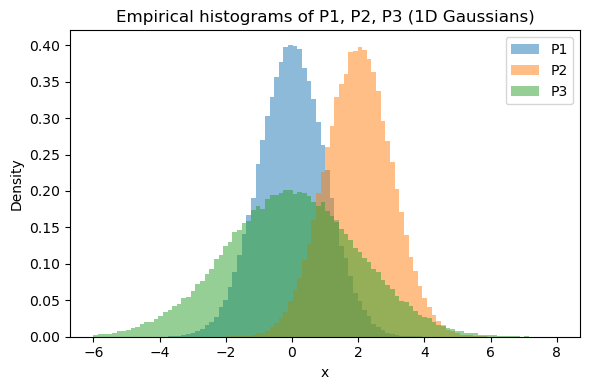

Saved histogram figure to: figs/wasserstein_1d_gaussians_hist.png


In [4]:
# Plot histograms of the three distributions
bins = 100
x_min = -6
x_max = 8

plt.figure(figsize=(6, 4))
for name in ["P1", "P2", "P3"]:
    plt.hist(samples[name], bins=bins, range=(x_min, x_max),
             density=True, alpha=0.5, label=name)

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Empirical histograms of P1, P2, P3 (1D Gaussians)")
plt.legend()
plt.tight_layout()

hist_path = os.path.join(fig_dir, "wasserstein_1d_gaussians_hist.png")
plt.savefig(hist_path, dpi=150)
plt.show()

print(f"Saved histogram figure to: {hist_path}")

## Quantile Functions

For a 1D distribution with cumulative distribution function (CDF) $F(x)$,
the **quantile function** is the inverse CDF:
$$
    F^{-1}(u) = \inf\{x : F(x) \ge u\}, \quad u \in (0,1).
$$

In 1D, the 1-Wasserstein distance has the representation:
$$
    W_1(P, Q)
    = \int_0^1 \bigl| F_P^{-1}(u) - F_Q^{-1}(u) \bigr| \, du.
$$

We will approximate these quantile functions empirically using sorted samples.


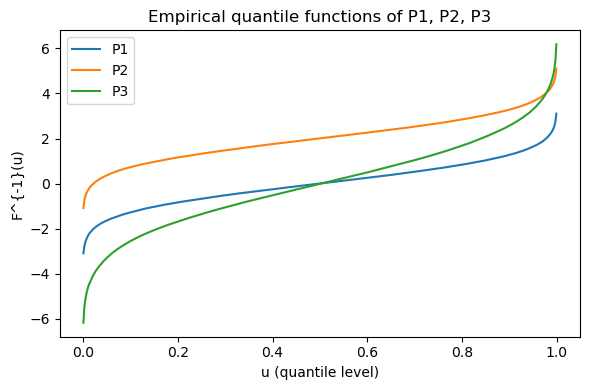

Saved quantile-function figure to: figs/wasserstein_1d_gaussians_quantiles.png


In [5]:
# Compute empirical quantiles by sorting samples
u = np.linspace(0.001, 0.999, 500)  # avoid extreme tails

quantiles = {}
for name in ["P1", "P2", "P3"]:
    sorted_samples = np.sort(samples[name])
    # Map quantile levels u to indices in the sorted sample
    idx = (u * (n_samples - 1)).astype(int)
    quantiles[name] = sorted_samples[idx]

# Plot quantile functions
plt.figure(figsize=(6, 4))
for name in ["P1", "P2", "P3"]:
    plt.plot(u, quantiles[name], label=name)

plt.xlabel("u (quantile level)")
plt.ylabel("F^{-1}(u)")
plt.title("Empirical quantile functions of P1, P2, P3")
plt.legend()
plt.tight_layout()

q_path = os.path.join(fig_dir, "wasserstein_1d_gaussians_quantiles.png")
plt.savefig(q_path, dpi=150)
plt.show()

print(f"Saved quantile-function figure to: {q_path}")

## Absolute Difference of Quantiles

The integrand in the 1D formula for $W_1$ is the absolute difference
of quantile functions:
$$
    |F_P^{-1}(u) - F_Q^{-1}(u)|.
$$

By plotting these curves, we directly visualize the local “transport cost’’
between two distributions as a function of the quantile level $ u $.


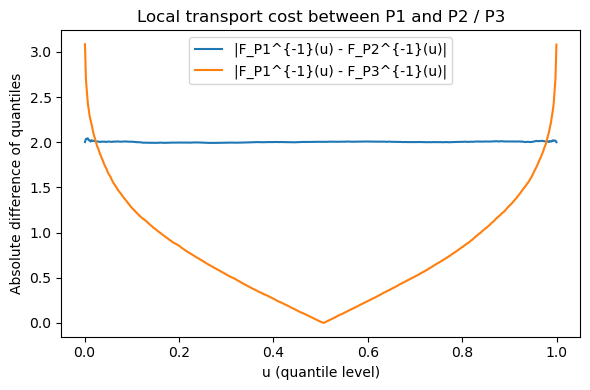

Saved transport-cost figure to: figs/wasserstein_1d_gaussians_transport.png


In [6]:
# Absolute difference of quantiles between (P1, P2) and (P1, P3)
diff_P1_P2 = np.abs(quantiles["P1"] - quantiles["P2"])
diff_P1_P3 = np.abs(quantiles["P1"] - quantiles["P3"])

plt.figure(figsize=(6, 4))
plt.plot(u, diff_P1_P2, label="|F_P1^{-1}(u) - F_P2^{-1}(u)|")
plt.plot(u, diff_P1_P3, label="|F_P1^{-1}(u) - F_P3^{-1}(u)|")
plt.xlabel("u (quantile level)")
plt.ylabel("Absolute difference of quantiles")
plt.title("Local transport cost between P1 and P2 / P3")
plt.legend()
plt.tight_layout()

diff_path = os.path.join(fig_dir, "wasserstein_1d_gaussians_transport.png")
plt.savefig(diff_path, dpi=150)
plt.show()

print(f"Saved transport-cost figure to: {diff_path}")

## Approximating \( W_1 \) from Quantiles

Using the empirical quantiles, we can approximate $W_1(P, Q)$ via
numerical integration:
$$
    W_1(P, Q) \approx \sum_k |F_P^{-1}(u_k) - F_Q^{-1}(u_k)| \, \Delta u.
$$

We compare this quantile-based approximation with `scipy.stats.wasserstein_distance`.


In [7]:
# Numerical integration over u to approximate W1 via quantiles
du = u[1] - u[0]

W1_P1_P2_quant = np.sum(diff_P1_P2) * du
W1_P1_P3_quant = np.sum(diff_P1_P3) * du

print("Quantile-based approximations of W1(P1, P2) and W1(P1, P3):")
print(f"  W1(P1, P2) ≈ {W1_P1_P2_quant:.4f}")
print(f"  W1(P1, P3) ≈ {W1_P1_P3_quant:.4f}")

# Compare with SciPy estimates
W1_P1_P2_scipy = wasserstein_distance(samples["P1"], samples["P2"])
W1_P1_P3_scipy = wasserstein_distance(samples["P1"], samples["P3"])

print("\nSciPy wasserstein_distance results (same pairs):")
print(f"  W1(P1, P2) ≈ {W1_P1_P2_scipy:.4f}")
print(f"  W1(P1, P3) ≈ {W1_P1_P3_scipy:.4f}")

Quantile-based approximations of W1(P1, P2) and W1(P1, P3):
  W1(P1, P2) ≈ 2.0035
  W1(P1, P3) ≈ 0.8020

SciPy wasserstein_distance results (same pairs):
  W1(P1, P2) ≈ 2.0035
  W1(P1, P3) ≈ 0.8021
